In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import sys
import msgpack as mp
import msgpack_numpy as mpn
sys.path.append(os.path.join(os.getcwd(), ".."))
from support.generate_ar_data import *
from support.pd_support import *
from support.calculations_support import *
from support.mecanum_calculations import *
from support.ar_calculations import *
import pandas as pd
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from tqdm import tqdm
import keyboard
import time
from IPython.display import display, clear_output
import seaborn as sns


In [4]:
_parent_folder = "single_cam_dec_14"
_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.join(_base_pth, "recording_programs", "test_data", _parent_folder)
_base_pth

'c:\\Users\\Sujith\\Documents\\Projects\\armbo\\recording_programs\\test_data\\single_cam_dec_14'

In [5]:
""" read excel sheet"""
folder_df = pd.read_excel(os.path.join(_base_pth, "00_analysis", "calibration_files.xlsx"))
_analysis_pth = os.path.join(_base_pth, "00_analysis")
folder_df

,folder_name,calibration_folder,flip
0,sk18_15_forward_fast,calibration_15fps_00,False
1,sk18_15_forward_fast_2,calibration_15fps_00,False
2,sk18_15_forward_medium,calibration_15fps_00,False
3,sk18_15_forward_medium_2,calibration_15fps_00,False
4,sk18_15_forward_slow,calibration_15fps_00,False
...,...,...,...
94,sk18_60_sideways_fast_2,calibration_60fps_00,False
95,sk18_60_sideways_medium,calibration_60fps_00,False
96,sk18_60_sideways_medium_2,calibration_60fps_00,False
97,sk18_60_sideways_slow,calibration_60fps_00,False


In [6]:
def transform_coordinates_1(df, rotmat, org):
    df1 = df.copy( deep=True)
    for i in range(len(df)):
        val = df[["x", "y", "z"]].loc[i].values
        val = np.reshape(val, (3,1))
        _temp = val - org
        translation_correction = np.array([0.045, -0.05, 0.045]).reshape(3, 1)
        _val = rotmat.T @ _temp
        _val = _val - translation_correction
        
        df1["x"].replace({df1["x"].loc[i]: _val[0]}, inplace=True)
        df1["y"].replace({df1["y"].loc[i]: _val[1]}, inplace=True)
        df1["z"].replace({df1["z"].loc[i]: _val[2]}, inplace=True)

    return df1

In [7]:
mean_err_df = pd.DataFrame(columns=["folder_name","date_created" ,"frame_id","err_x", "err_y", "err_z",
                                     "max_err_x", "max_err_y", "max_err_z",
                                     "std_err_x", "std_err_y", "std_err_z",
                                     "offset_x", "offset_y", "offset_z"])

In [9]:
for idx, _folder_name in enumerate(tqdm(folder_df.folder_name)):
    # print(idx)
    _phone_cam_folder = os.path.join(_analysis_pth, "coordinates_ar", _folder_name + ".csv")
    _mc_folder = os.path.join(_analysis_pth, "coordinates_mc", _folder_name + ".csv")

    _phone_cam_df = pd.read_csv(_phone_cam_folder)
    _mc_df = pd.read_csv(_mc_folder)

    #read the calibration file
    _webcam_calib_folder = folder_df.calibration_folder[idx]
    _webcam_calib_folder = os.path.join(_base_pth, _webcam_calib_folder)

    with open(os.path.join(_webcam_calib_folder, "webcam_rotmat.msgpack"), "rb") as f:
        webcam_rotmat = mp.Unpacker(f, object_hook=mpn.decode)
        _webcam_rot = next(webcam_rotmat)
        _webcam_org = next(webcam_rotmat)


    _w_df = transform_coordinates_1(_phone_cam_df, _webcam_rot, _webcam_org)
    _w_df.time = pd.to_datetime(_w_df.time)
    _mc_df.time = pd.to_datetime(_mc_df.time)

    # find the offset
    _offset_x = _w_df.x.iloc[0] - _mc_df.x.iloc[0]
    _offset_y = _w_df.y.iloc[0] - _mc_df.y.iloc[0]
    _offset_z = _w_df.z.iloc[0] - _mc_df.z.iloc[0]

    _mc_df.x = _mc_df.x + _offset_x
    _mc_df.y = _mc_df.y + _offset_y
    _mc_df.z = _mc_df.z + _offset_z


    # filter the data
    _w_df.x = savgol_filter(_w_df.x, 51, 1)
    _w_df.y = savgol_filter(_w_df.y, 51, 1)
    _w_df.z = savgol_filter(_w_df.z, 51, 1)
    
    error_df = pd.DataFrame()
    error_df["time"] = _mc_df["time"]
    error_df["x"] = _mc_df["x"] - _w_df["x"]
    error_df["y"] = _mc_df["y"] - _w_df["y"]
    error_df["z"] = _mc_df["z"] - _w_df["z"]
    error_df["frame_id"] = _w_df["frame_id"]

    mean_err_df = mean_err_df.append({"folder_name": folder_df.folder_name[idx],"date_created": None, "frame_id":  error_df["frame_id"][0],
                                    "err_x": error_df["x"].mean(), "err_y": error_df["y"].mean(), "err_z": error_df["z"].mean(), 
                                    "max_err_x": error_df["x"].max(), "max_err_y": error_df["y"].max(), "max_err_z": error_df["z"].max(), 
                                    "std_err_x": error_df["x"].std(), "std_err_y": error_df["y"].std(), "std_err_z": error_df["z"].std(),
                                    "offset_x": _offset_x, "offset_y": _offset_y, "offset_z": _offset_z}, ignore_index=True)

    

100%|██████████| 99/99 [14:04<00:00,  8.54s/it]


,folder_name,date_created,frame_id,err_x,err_y,err_z,max_err_x,max_err_y,max_err_z,std_err_x,std_err_y,std_err_z,offset_x,offset_y,offset_z
0,sk18_15_forward_fast,None,5.0,-0.001733,0.001650,0.005229,0.005508,0.009216,0.077408,0.004531,0.002418,0.030697,-0.025135,-0.069383,-0.377925
1,sk18_15_forward_fast_2,None,5.0,-0.003599,-0.000457,-0.025827,0.005258,0.007093,0.019476,0.003811,0.001972,0.032416,-0.029326,-0.071818,-0.427718
2,sk18_15_forward_medium,None,5.0,-0.002427,-0.007972,-0.043691,0.006560,-0.002821,0.015398,0.003637,0.002068,0.031950,-0.024298,-0.078700,-0.424139
3,sk18_15_forward_medium_2,None,5.0,-0.006071,0.007313,0.017804,0.005742,0.013907,0.072832,0.006943,0.002736,0.029392,-0.028950,-0.063480,-0.372075
4,sk18_15_forward_slow,None,5.0,-0.001635,0.000087,-0.023786,0.004973,0.005365,0.020133,0.003328,0.002117,0.032445,-0.028681,-0.071000,-0.411418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,sk18_60_sideways_fast_2,None,5.0,0.001821,0.004142,0.015081,0.061259,0.016282,0.061709,0.016103,0.003322,0.011692,0.007030,-0.065490,-0.368053
95,sk18_60_sideways_medium,None,5.0,0.006224,-0.017928,-0.091997,0.071570,-0.001471,-0.006854,0.026612,0.006393,0.028113,0.021920,-0.091871,-0.510407
96,sk18_60_sideways_medium_2,None,5.0,0.008255,-0.005471,-0.024627,0.074654,0.001499,0.000011,0.024552,0.006019,0.024246,0.015719,-0.082591,-0.445881
97,sk18_60_sideways_slow,None,5.0,0.006528,-0.004492,-0.046539,0.174055,0.008366,0.000074,0.036396,0.004766,0.019189,0.019599,-0.075307,-0.446643


In [11]:
# save the mean error
_mean_df_pth = os.path.join(_analysis_pth, "mean_error_df_filter.csv")
mean_err_df.to_csv(_mean_df_pth, index=False)

# read the mean error df
mean_err_df = pd.read_csv(os.path.join(_analysis_pth, "mean_error_df_filter.csv"))
mean_err_df

,folder_name,date_created,frame_id,err_x,err_y,err_z,max_err_x,max_err_y,max_err_z,std_err_x,std_err_y,std_err_z,offset_x,offset_y,offset_z
0,sk18_15_forward_fast,NaN,5.0,-0.001733,0.001650,0.005229,0.005508,0.009216,0.077408,0.004531,0.002418,0.030697,-0.025135,-0.069383,-0.377925
1,sk18_15_forward_fast_2,NaN,5.0,-0.003599,-0.000457,-0.025827,0.005258,0.007093,0.019476,0.003811,0.001972,0.032416,-0.029326,-0.071818,-0.427718
2,sk18_15_forward_medium,NaN,5.0,-0.002427,-0.007972,-0.043691,0.006560,-0.002821,0.015398,0.003637,0.002068,0.031950,-0.024298,-0.078700,-0.424139
3,sk18_15_forward_medium_2,NaN,5.0,-0.006071,0.007313,0.017804,0.005742,0.013907,0.072832,0.006943,0.002736,0.029392,-0.028950,-0.063480,-0.372075
4,sk18_15_forward_slow,NaN,5.0,-0.001635,0.000087,-0.023786,0.004973,0.005365,0.020133,0.003328,0.002117,0.032445,-0.028681,-0.071000,-0.411418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,sk18_60_sideways_fast_2,NaN,5.0,0.001821,0.004142,0.015081,0.061259,0.016282,0.061709,0.016103,0.003322,0.011692,0.007030,-0.065490,-0.368053
95,sk18_60_sideways_medium,NaN,5.0,0.006224,-0.017928,-0.091997,0.071570,-0.001471,-0.006854,0.026612,0.006393,0.028113,0.021920,-0.091871,-0.510407
96,sk18_60_sideways_medium_2,NaN,5.0,0.008255,-0.005471,-0.024627,0.074654,0.001499,0.000011,0.024552,0.006019,0.024246,0.015719,-0.082591,-0.445881
97,sk18_60_sideways_slow,NaN,5.0,0.006528,-0.004492,-0.046539,0.174055,0.008366,0.000074,0.036396,0.004766,0.019189,0.019599,-0.075307,-0.446643


In [12]:
# find fps using filename
fps_values = []
for i in mean_err_df.folder_name:
    _fps = i.split("_")[1]
    _fps = int(_fps)
    fps_values.append(_fps)
mean_err_df["fps"] = fps_values

# find speed of movement
speed_values = []
for i in mean_err_df.folder_name:
    _speed = i.split("_")[3]
    speed_values.append(_speed)
mean_err_df["speed"] = speed_values

#object of movement
object_values = []
for i in mean_err_df.folder_name:
    _object = i.split("_")[2]
    
    if _object == "quad":
        object_values.append("quad")
    else:
        object_values.append("skateboard")
mean_err_df["object"] = object_values

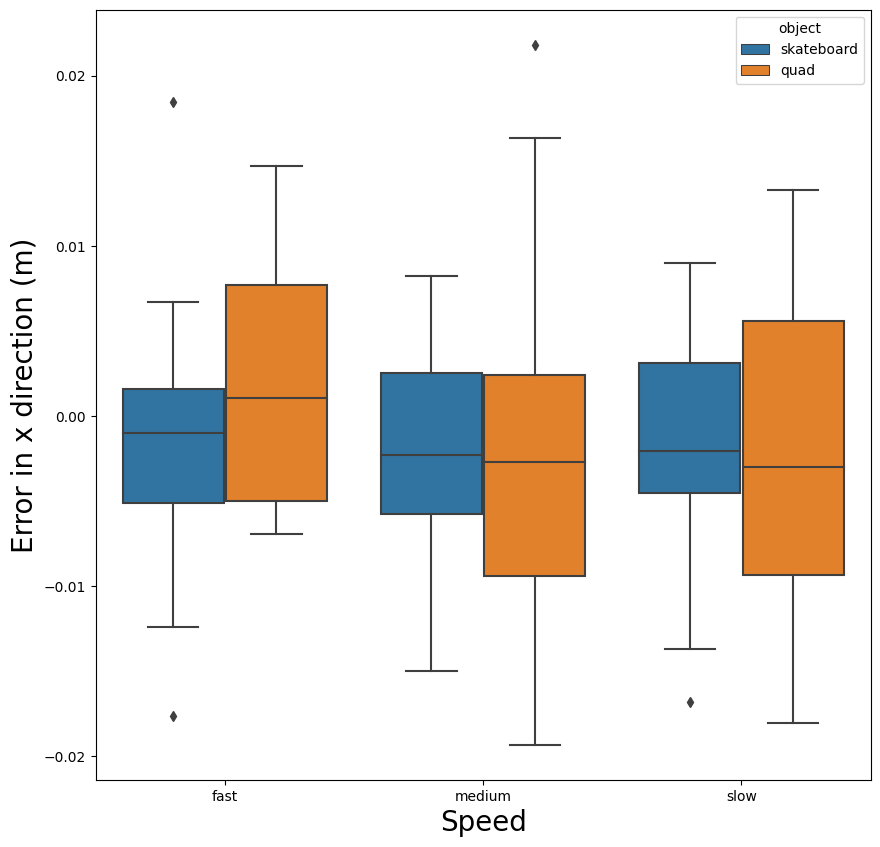

In [17]:
# box plot based on speed
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(x="speed", y="err_x", hue="object", data=mean_err_df, ax=ax)

# label
ax.set_xlabel("Speed", fontsize=20)
ax.set_ylabel("Error in x direction (m)", fontsize=20)
plt.show()

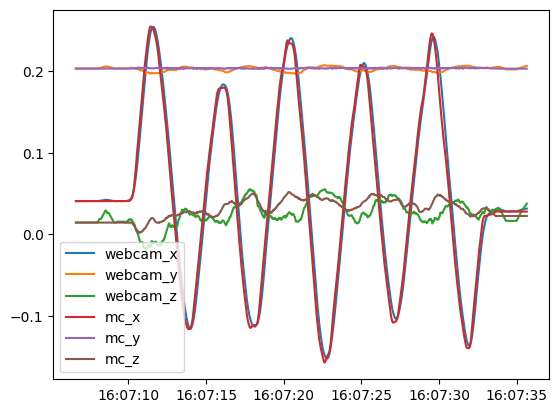

In [ ]:
# plot _w_df and _mc_df
w_df = _w_df.copy(deep=True)

w_df.x = savgol_filter(_w_df.x, 51, 1)
w_df.y = savgol_filter(_w_df.y, 51, 1)
w_df.z = savgol_filter(_w_df.z, 51, 1)
plt.plot(_w_df.time, w_df.x, label="webcam_x")
plt.plot(_w_df.time, w_df.y, label="webcam_y")
plt.plot(_w_df.time, w_df.z, label="webcam_z")
plt.plot(_mc_df.time, _mc_df.x, label="mc_x")
plt.plot(_mc_df.time, _mc_df.y, label="mc_y")
plt.plot(_mc_df.time, _mc_df.z, label="mc_z")


plt.legend()